In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score

from copy import deepcopy
import missingno as msno
import time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

from scipy.stats import shapiro
from scipy import stats
from scipy.stats import kruskal
from tqdm import tqdm

from LRE import LogisticRegressionEnsemble

# The necessary EDA steps that has to be done for the logistic regression ensemble is the following:

- Handle missing values
- Feature Scaling of continuous features
- One hot encode the categorical features
- Encode the target features

# Ionosphere dataset

In [3]:
feature_names = [i for i in range(1,34)]
feature_names[-1] = "target"
ion_df = pd.read_csv("data/ionosphere/ionosphere.data", header=None, names=feature_names)
ion_df

1        2        3        4        5        6        7        8  \
1 0  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.00000  0.03760   
  0  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.00000 -0.04549   
  0  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062  0.88965  0.01198   
  0  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000  0.00000  0.00000   
  0  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255  0.77152 -0.16399   
..       ...      ...      ...      ...      ...      ...      ...      ...   
  0  0.83508  0.08298  0.73739 -0.14706  0.84349 -0.05567  0.90441 -0.04622   
  0  0.95113  0.00419  0.95183 -0.02723  0.93438 -0.01920  0.94590  0.01606   
  0  0.94701 -0.00034  0.93207 -0.03227  0.95177 -0.03431  0.95584  0.02446   
  0  0.90608 -0.01657  0.98122 -0.01989  0.95691 -0.03646  0.85746  0.00110   
  0  0.84710  0.13533  0.73638 -0.06151  0.87873  0.08260  0.88928 -0.09139   

           9       10  ...       24       25       26       27       28  \
1 0  0.85243 -0.17755  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090   
  0  0.50874 -0.67743  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593   
  0  0.73082  0.05346  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365   
  0  0.00000  0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099   
  0  0.52798 -0.20275  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197   
..       ...      ...  ...      ...      ...      ...      ...      ...   
  0  0.89391  0.13130  ... -0.04202  0.83479  0.00123  1.00000  0.12815   
  0  0.96510  0.03281  ...  0.01361  0.93522  0.04925  0.93159  0.08168   
  0  0.94124  0.01766  ...  0.03193  0.92489  0.02542  0.92120  0.02242   
  0  0.89724 -0.03315  ... -0.02099  0.89147 -0.07760  0.82983 -0.17238   
  0  0.78735  0.06678  ... -0.15114  0.81147 -0.04822  0.78207 -0.00703   

          29       30       31       32  target  
1 0  0.42267 -0.54487  0.18641 -0.45300       g  
  0 -0.16626 -0.06288 -0.13738 -0.02447       b  
  0  0.60436 -0.24180  0.56045 -0.38238       g  
  0  0.25682  1.00000 -0.32382  1.00000       b  
  0 -0.05707 -0.59573 -0.04608 -0.65697       g  
..       ...      ...      ...      ...     ...  
  0  0.86660 -0.10714  0.90546 -0.04307       g  
  0  0.94066 -0.00035  0.91483  0.04712       g  
  0  0.92459  0.00442  0.92697 -0.00577       g  
  0  0.96022 -0.03757  0.87403 -0.16243       g  
  0  0.75747 -0.06678  0.85764 -0.06151       g  

[351 rows x 33 columns]

In [4]:
X = ion_df.drop("target", axis=1)
y = ion_df['target']

In [5]:
X_norm = 2 * ((X - X.min()) / (X.max() - X.min())) - 1
X_norm.describe()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,0.476183,0.155040,...,0.396135,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480
std,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,0.563496,0.494817,...,0.578451,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,0.021120,-0.065265,...,0.000000,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350
50%,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,0.667980,0.028250,...,0.553890,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000
75%,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,0.957895,0.482375,...,0.905240,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
y_encoded = [0 if u == 'b' else 1 for u in y]
y_encoded = np.asarray(y_encoded)
X_final = np.asarray(X_norm)

### Start by using Bayesian optimisation to tune the learning rate, epochs and patience parameters

In [37]:
def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = X[test_indices], y[test_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Unpack model parameters
    eta, num_epochs, patience = model_params

    # Initialize the model with the current set of hyperparameters
    model = LogisticRegressionEnsemble(num_models=1, learning_rate=eta, iterations=num_epochs, patience=patience, num_features=1)

    model.random_state = fold_num
    weights, loss = model.fit_single_model(model.apply_polynomial_features(X_train), y_train, X_val=model.apply_polynomial_features(X_val), y_val=y_val, curr_iteration=fold_num)
    y_pred = np.asarray([0 if u < 0.5 else 1 for u in model.sigmoid(model.apply_polynomial_features(X_test) @ weights)])
    score = model.f1_score(y_test, y_pred)
    return 1-score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[i-1][1]
        train_indices = np.concatenate([folds[j][1] for j in range(len(folds)) if j not in [i, i-1]])
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    scores_acc = np.mean(scores)
    scores_std = np.std(scores)
    return (scores_acc + scores_std) / 2

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_final, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1e-1, "log-uniform", name='eta'),
    Integer(1000, 30000, name='num_epochs'),
    Integer(5, 10, name='patience'),
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=42,
    noise=1e-8,
    n_jobs = 1,
    acq_func='EI',  # Expected Improvement acquisition function
    acq_optimizer='auto',
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Number of epochs units: {result.x[1]}")
print(f"Patience: {result.x[2]}")

Iteration No: 1 started. Evaluating function at random point.
[0.024526126311336792, 6320, 9]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4507
Function value obtained: 0.0655
Current minimum: 0.0655
Iteration No: 2 started. Evaluating function at random point.
[0.006173770394704579, 13929, 5]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2312
Function value obtained: 0.0666
Current minimum: 0.0655
Iteration No: 3 started. Evaluating function at random point.
[0.0023864188780056083, 10678, 6]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9663
Function value obtained: 0.0666
Current minimum: 0.0655
Iteration No: 4 started. Evaluating function at random point.
[0.008967376801947965, 2636, 9]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2701
Function value obtained: 0.0666
Current minimum: 0.0655
Iteration No: 5 started. Evaluating function at random point.
[0.06541210527692738, 1023, 10]
Ite

In [7]:
# Define the parameter grid
bag_size_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_features_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_models_values = [5, 10, 20, 50, 100]

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=["bag_size", "num_features", "num_models", "fold", "f1_score"])

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each parameter combination
for bag_size in tqdm(bag_size_values):
    for num_features in num_features_values:
        for num_models in num_models_values:
            f1_scores = []

            # Perform cross-validation
            for fold, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X_final[train_index], X_final[test_index]
                y_train, y_test = y_encoded[train_index], y_encoded[test_index]
                
                # Create and fit the ensemble model
                model = LogisticRegressionEnsemble(
                    num_models=num_models, bag_size=bag_size, num_features=num_features, n_jobs=6, learning_rate=0.00011850345598328692,
                    patience=6, iterations=9809, random_state=42)
                model.fit(X_train, y_train)
                
                # Predict and evaluate F1 score
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred)
                
                # Append results for each fold
                results = pd.concat([results, pd.DataFrame([{
                        "bag_size": bag_size,
                        "num_features": num_features,
                        "num_models": num_models,
                        "fold": fold + 1,
                        "f1_score": f1
                    }])], ignore_index=True)

# Save the results DataFrame to a JSON file
results.to_csv("results/ionosphere_linear_results.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:00:15<00:00, 1443.16s/it]


## Non linear logistic regression

In [38]:
def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = X[test_indices], y[test_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Unpack model parameters
    eta, num_epochs, patience, num_nonlinear_features, polynomial_degree = model_params

    # Initialize the model with the current set of hyperparameters
    model = LogisticRegressionEnsemble(num_models=1, learning_rate=eta, iterations=num_epochs, patience=patience, polynomial_degree=polynomial_degree,
                                       num_features=1, num_nonlinear_features=num_nonlinear_features)

    model.random_state = fold_num

    X_transform = model.apply_polynomial_features(X_train)
    nonlinear_feature_idx = model.select_random_features(X_transform, fold_num)
    
    weights, loss = model.fit_single_model(X_transform[:, nonlinear_feature_idx], y_train, X_val=model.apply_polynomial_features(X_val)[:, nonlinear_feature_idx], y_val=y_val, curr_iteration=fold_num)
    y_pred = np.asarray([0 if u < 0.5 else 1 for u in model.sigmoid(model.apply_polynomial_features(X_test)[:,nonlinear_feature_idx] @ weights)])
    score = model.f1_score(y_test, y_pred)
    return 1-score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[i-1][1]
        train_indices = np.concatenate([folds[j][1] for j in range(len(folds)) if j not in [i, i-1]])
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    scores_acc = np.mean(scores)
    scores_std = np.std(scores)
    return (scores_acc + scores_std) / 2

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_final, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1e-1, "log-uniform", name='eta'),
    Integer(1000, 30000, name='num_epochs'),
    Integer(5, 10, name='patience'),
    Categorical([0.4, 0.5, 0.6, 0.7, 0.8], name='num_nonlinear_features'),
    Integer(2,3, name='polynomial_degree')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=42,
    noise=1e-8,
    n_jobs = 1,
    acq_func='EI',  # Expected Improvement acquisition function
    acq_optimizer='auto',
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Number of epochs units: {result.x[1]}")
print(f"Patience: {result.x[2]}")
print(f"Number of nonlinear features: {result.x[3]}")
print(f"Polynomial degree: {result.x[4]}")

Iteration No: 1 started. Evaluating function at random point.
[0.024526126311336792, 6320, 9, 0.6, 2]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.9713
Function value obtained: 0.0467
Current minimum: 0.0467
Iteration No: 2 started. Evaluating function at random point.
[0.00019949166150633933, 14318, 7, 0.4, 3]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 41.5045
Function value obtained: 0.0431
Current minimum: 0.0431
Iteration No: 3 started. Evaluating function at random point.
[0.00014765043713594345, 21938, 10, 0.4, 3]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 52.9077
Function value obtained: 0.0431
Current minimum: 0.0431
Iteration No: 4 started. Evaluating function at random point.
[0.007119418600172993, 18738, 5, 0.4, 3]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.2774
Function value obtained: 0.0433
Current minimum: 0.0431
Iteration No: 5 started. Evaluating function at random po

In [8]:
# Define the parameter grid
bag_size_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_features_values = [0.4, 0.5, 0.6, 0.7, 0.8]
num_models_values = [5, 10, 20, 50, 100]
# Initialize a DataFrame to store results
nl_results = pd.DataFrame(columns=["bag_size", "num_features", "num_models", "fold", "f1_score"])

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each parameter combination
for bag_size in tqdm(bag_size_values):
    for num_features in num_features_values:
        for num_models in num_models_values:
            f1_scores = []

            # Perform cross-validation
            for fold, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = X_final[train_index], X_final[test_index]
                y_train, y_test = y_encoded[train_index], y_encoded[test_index]
                
                # Create and fit the ensemble model
                model = LogisticRegressionEnsemble(
                    num_models=num_models,
                    bag_size=bag_size,
                    num_features=num_features,
                    n_jobs=6,
                    learning_rate=0.00010199699620384331,
                    patience=10,
                    polynomial_degree=3,
                    num_nonlinear_features=0.7,
                    iterations=2797,
                    random_state=42
                )
                model.fit(X_train, y_train)
                
                # Predict and evaluate F1 score
                y_pred = model.predict(X_test)
                f1 = f1_score(y_test, y_pred)
                
                # Append results for each fold
                nl_results = pd.concat([nl_results, pd.DataFrame([{
                        "bag_size": bag_size,
                        "num_features": num_features,
                        "num_models": num_models,
                        "fold": fold + 1,
                        "f1_score": f1
                    }])], ignore_index=True)
# Save the results DataFrame to a JSON file
nl_results.to_csv("results/ionosphere_nonlinear_results.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [4:19:33<00:00, 3114.62s/it]


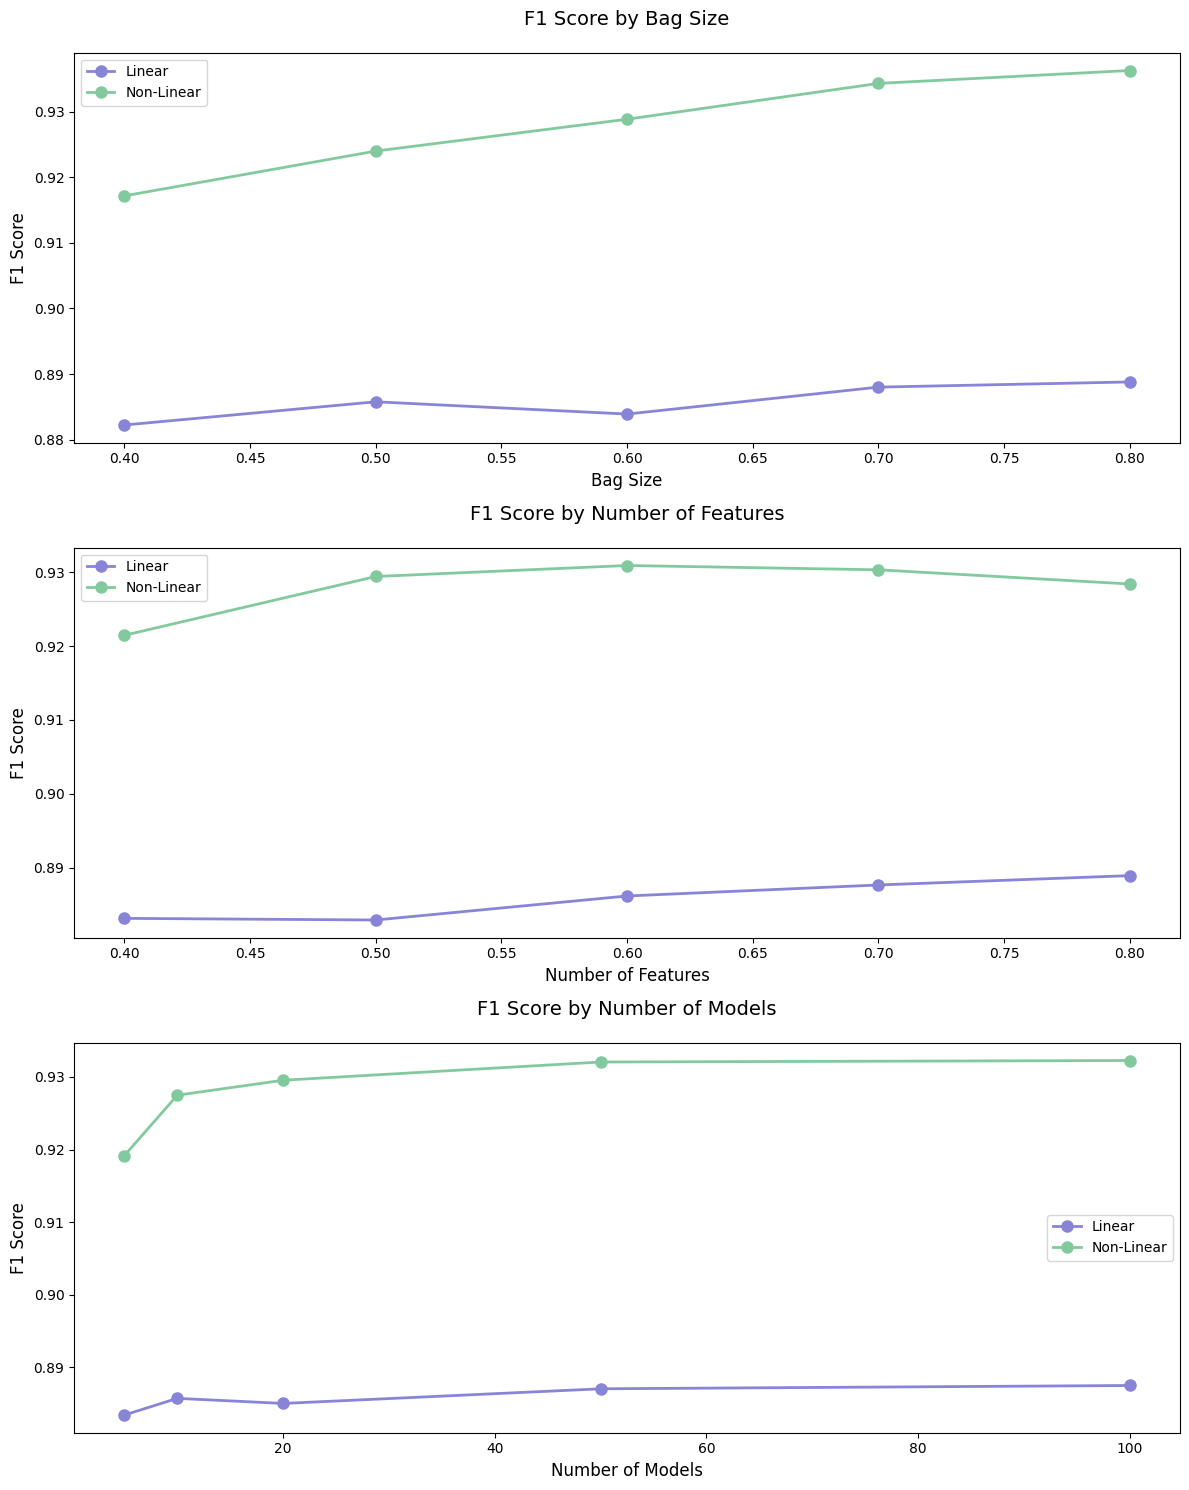


Summary Statistics:

Linear Dataset:
bag_size  num_features  num_models
0.4       0.4           5             0.8782
                        10            0.8729
                        20            0.8802
                        50            0.8821
                        100           0.8779
                                       ...  
0.8       0.8           5             0.8940
                        10            0.8902
                        20            0.8903
                        50            0.8904
                        100           0.8888
Name: f1_score, Length: 125, dtype: float64

Non-Linear Dataset:
bag_size  num_features  num_models
0.4       0.4           5             0.8936
                        10            0.9067
                        20            0.8952
                        50            0.9099
                        100           0.9043
                                       ...  
0.8       0.8           5             0.9283
                 

In [9]:
def create_comparison_plots(results, nl_results):
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Function to process data for each grouping
    def process_data(df, group_by):
        grouped = df.groupby(group_by)['f1_score'].mean().reset_index()
        # Ensure numeric types and sorting
        grouped[group_by] = pd.to_numeric(grouped[group_by])
        grouped['f1_score'] = pd.to_numeric(grouped['f1_score'])
        return grouped.sort_values(group_by)
    
    # Colors for consistency
    colors = ['#8884d8', '#82ca9d']
    
    # Plot 1: Bag Size Comparison
    data1 = process_data(results, 'bag_size')
    data2 = process_data(nl_results, 'bag_size')
    
    ax1.plot(data1['bag_size'], data1['f1_score'], '-o', color=colors[0], label='Linear', linewidth=2, markersize=8)
    ax1.plot(data2['bag_size'], data2['f1_score'], '-o', color=colors[1], label='Non-Linear', linewidth=2, markersize=8)
    ax1.set_title('F1 Score by Bag Size', fontsize=14, pad=20)
    ax1.set_xlabel('Bag Size', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.legend(fontsize=10)
    # ax1.grid(True, linestyle='--', alpha=0.7)
    # ax1.set_ylim(0.7, 0.9)
    
    # Plot 2: Number of Features Comparison
    data1 = process_data(results, 'num_features')
    data2 = process_data(nl_results, 'num_features')
    
    ax2.plot(data1['num_features'], data1['f1_score'], '-o', color=colors[0], label='Linear', linewidth=2, markersize=8)
    ax2.plot(data2['num_features'], data2['f1_score'], '-o', color=colors[1], label='Non-Linear', linewidth=2, markersize=8)
    ax2.set_title('F1 Score by Number of Features', fontsize=14, pad=20)
    ax2.set_xlabel('Number of Features', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.legend(fontsize=10)
    # ax2.grid(True, linestyle='--', alpha=0.7)
    # ax2.set_ylim(0.7, 0.9)
    
    # Plot 3: Number of Models Comparison
    data1 = process_data(results, 'num_models')
    data2 = process_data(nl_results, 'num_models')
    
    ax3.plot(data1['num_models'], data1['f1_score'], '-o', color=colors[0], label='Linear', linewidth=2, markersize=8)
    ax3.plot(data2['num_models'], data2['f1_score'], '-o', color=colors[1], label='Non-Linear', linewidth=2, markersize=8)
    ax3.set_title('F1 Score by Number of Models', fontsize=14, pad=20)
    ax3.set_xlabel('Number of Models', fontsize=12)
    ax3.set_ylabel('F1 Score', fontsize=12)
    ax3.legend(fontsize=10)
    # ax3.grid(True, linestyle='--', alpha=0.7)
    # ax3.set_ylim(0.7, 0.9)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nLinear Dataset:")
    summary1 = results.groupby(['bag_size', 'num_features', 'num_models'])['f1_score'].mean().round(4)
    print(summary1)
    print("\nNon-Linear Dataset:")
    summary2 = nl_results.groupby(['bag_size', 'num_features', 'num_models'])['f1_score'].mean().round(4)
    print(summary2)

# Load your datasets
results = pd.read_csv('results/ionosphere_linear_results.csv')
nl_results = pd.read_csv('results/ionosphere_nonlinear_results.csv')

# Create the comparison plots
create_comparison_plots(results, nl_results)

In [10]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import Tuple, Dict

def perform_statistical_analysis(linear_df: pd.DataFrame, 
                               nonlinear_df: pd.DataFrame) -> Dict:
    """
    Performs comprehensive statistical analysis comparing F1 scores between linear and nonlinear models.
    
    Parameters:
    -----------
    linear_df : pd.DataFrame
        DataFrame containing results from linear models
    nonlinear_df : pd.DataFrame
        DataFrame containing results from non-linear models
        
    Returns:
    --------
    Dict containing test results for different comparisons
    """
    results = {}
    
    # Overall comparison
    linear_scores = linear_df['f1_score']
    nonlinear_scores = nonlinear_df['f1_score']
    
    # 1. Shapiro-Wilk test for normality
    results['normality_test'] = {
        'linear': stats.shapiro(linear_scores),
        'nonlinear': stats.shapiro(nonlinear_scores)
    }
    
    # 2. Mann-Whitney U test (non-parametric)
    results['mann_whitney'] = stats.mannwhitneyu(
        linear_scores, 
        nonlinear_scores,
        alternative='two-sided'
    )
    
    # 3. Paired groupwise comparisons
    grouped_comparisons = {}
    
    # For each parameter (bag_size, num_features, num_models)
    for param in ['bag_size', 'num_features', 'num_models']:
        param_results = []
        
        # Group by the parameter and calculate mean F1 scores
        linear_grouped = linear_df.groupby(param)['f1_score'].mean()
        nonlinear_grouped = nonlinear_df.groupby(param)['f1_score'].mean()
        
        # Ensure we're comparing the same parameter values
        common_params = set(linear_grouped.index) & set(nonlinear_grouped.index)
        
        if len(common_params) > 1:  # Need at least 2 points for correlation
            linear_values = [linear_grouped[p] for p in common_params]
            nonlinear_values = [nonlinear_grouped[p] for p in common_params]
            
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(linear_values, nonlinear_values)
            
            # Correlation test
            correlation, corr_p_value = stats.pearsonr(linear_values, nonlinear_values)
            
            param_results = {
                'paired_ttest': (t_stat, p_value),
                'correlation': (correlation, corr_p_value),
                'mean_difference': np.mean(linear_values) - np.mean(nonlinear_values),
                'std_difference': np.std(linear_values) - np.std(nonlinear_values)
            }
            
        grouped_comparisons[param] = param_results
    
    results['grouped_comparisons'] = grouped_comparisons
    
    return results

def print_analysis_results(results: Dict) -> None:
    """
    Prints the statistical analysis results in a readable format.
    
    Parameters:
    -----------
    results : Dict
        Dictionary containing the statistical test results
    """
    print("\nSTATISTICAL ANALYSIS RESULTS")
    print("=" * 50)
    
    # Normality Test Results
    print("\n1. Normality Tests (Shapiro-Wilk)")
    print("-" * 30)
    for model_type, (statistic, p_value) in results['normality_test'].items():
        print(f"{model_type.title()} models:")
        print(f"  Statistic: {statistic:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Normal distribution: {p_value > 0.05}\n")
    
    # Mann-Whitney U Test Results
    print("\n2. Mann-Whitney U Test (Overall Comparison)")
    print("-" * 30)
    mw_stat, mw_p = results['mann_whitney']
    print(f"Statistic: {mw_stat:.4f}")
    print(f"p-value: {mw_p:.4f}")
    print(f"Significant difference: {mw_p < 0.05}")
    
    # Grouped Comparisons
    print("\n3. Grouped Comparisons")
    print("-" * 30)
    for param, param_results in results['grouped_comparisons'].items():
        if param_results:  # If we have results for this parameter
            print(f"\n{param.replace('_', ' ').title()} Analysis:")
            
            t_stat, p_value = param_results['paired_ttest']
            print(f"Paired t-test:")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significant difference: {p_value < 0.05}")
            
            corr, corr_p = param_results['correlation']
            print(f"\nCorrelation:")
            print(f"  Correlation coefficient: {corr:.4f}")
            print(f"  p-value: {corr_p:.4f}")
            print(f"  Significant correlation: {corr_p < 0.05}")
            
            print(f"\nDifferences:")
            print(f"  Mean difference: {param_results['mean_difference']:.4f}")
            print(f"  Std difference: {param_results['std_difference']:.4f}")

# Example usage:
if __name__ == "__main__":
    # Assuming results and nl_results are your DataFrames
    statistical_results = perform_statistical_analysis(results, nl_results)
    print_analysis_results(statistical_results)


STATISTICAL ANALYSIS RESULTS

1. Normality Tests (Shapiro-Wilk)
------------------------------
Linear models:
  Statistic: 0.9518
  p-value: 0.0000
  Normal distribution: False

Nonlinear models:
  Statistic: 0.9684
  p-value: 0.0000
  Normal distribution: False


2. Mann-Whitney U Test (Overall Comparison)
------------------------------
Statistic: 31010.5000
p-value: 0.0000
Significant difference: True

3. Grouped Comparisons
------------------------------

Bag Size Analysis:
Paired t-test:
  t-statistic: -17.2473
  p-value: 0.0001
  Significant difference: True

Correlation:
  Correlation coefficient: 0.8877
  p-value: 0.0444
  Significant correlation: True

Differences:
  Mean difference: -0.0424
  Std difference: -0.0045

Num Features Analysis:
Paired t-test:
  t-statistic: -27.4732
  p-value: 0.0000
  Significant difference: True

Correlation:
  Correlation coefficient: 0.4863
  p-value: 0.4061
  Significant correlation: False

Differences:
  Mean difference: -0.0424
  Std differ

In [11]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import Dict, List
import itertools

def analyze_single_dataframe(df: pd.DataFrame, group_columns: List[str]) -> Dict:
    """
    Performs comprehensive statistical analysis on groups within a single dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the results
    group_columns : List[str]
        List of columns to analyze (e.g., ['bag_size', 'num_features', 'num_models'])
        
    Returns:
    --------
    Dict containing test results for different comparisons
    """
    results = {}
    
    for column in group_columns:
        # Get unique values for the current parameter
        unique_values = sorted(df[column].unique())
        
        # Store results for this parameter
        param_results = {
            'kruskal_wallis': None,
            'pairwise_comparisons': [],
            'descriptive_stats': None,
            'effect_size': None
        }
        
        # 1. Kruskal-Wallis H-test (non-parametric ANOVA)
        groups = [df[df[column] == val]['f1_score'] for val in unique_values]
        h_stat, p_value = stats.kruskal(*groups)
        param_results['kruskal_wallis'] = {
            'statistic': h_stat,
            'p_value': p_value
        }
        
        # 2. Pairwise Mann-Whitney U tests with Bonferroni correction
        pairs = list(itertools.combinations(unique_values, 2))
        n_pairs = len(pairs)
        
        for val1, val2 in pairs:
            group1 = df[df[column] == val1]['f1_score']
            group2 = df[df[column] == val2]['f1_score']
            
            # Perform Mann-Whitney U test
            stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            
            # Calculate effect size (r = Z / sqrt(N))
            n1, n2 = len(group1), len(group2)
            z_score = stats.norm.ppf(p_value / 2)  # Convert p-value to z-score
            effect_size = abs(z_score) / np.sqrt(n1 + n2)
            
            param_results['pairwise_comparisons'].append({
                'group1': val1,
                'group2': val2,
                'statistic': stat,
                'p_value': p_value,
                'p_value_adjusted': min(p_value * n_pairs, 1.0),  # Bonferroni correction
                'effect_size': effect_size
            })
        
        # 3. Descriptive statistics
        desc_stats = df.groupby(column)['f1_score'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(4)
        param_results['descriptive_stats'] = desc_stats
        
        # Store results for this parameter
        results[column] = param_results
    
    return results

def print_single_df_analysis(results: Dict) -> None:
    """
    Prints the statistical analysis results in a readable format.
    
    Parameters:
    -----------
    results : Dict
        Dictionary containing the statistical test results
    """
    print("\nSINGLE DATAFRAME STATISTICAL ANALYSIS")
    print("=" * 50)
    
    for param, param_results in results.items():
        print(f"\nAnalysis for {param.replace('_', ' ').title()}")
        print("-" * 40)
        
        # 1. Print Kruskal-Wallis results
        kw = param_results['kruskal_wallis']
        print("\nKruskal-Wallis H-test:")
        print(f"H-statistic: {kw['statistic']:.4f}")
        print(f"p-value: {kw['p_value']:.4f}")
        print(f"Significant differences exist: {kw['p_value'] < 0.05}")
        
        # 2. Print descriptive statistics
        print("\nDescriptive Statistics:")
        print(param_results['descriptive_stats'])
        
        # 3. Print pairwise comparisons
        print("\nPairwise Comparisons (Mann-Whitney U with Bonferroni correction):")
        significant_pairs = []
        for comp in param_results['pairwise_comparisons']:
            if comp['p_value_adjusted'] < 0.05:
                significant_pairs.append(comp)
                print(f"\n{comp['group1']} vs {comp['group2']}:")
                print(f"  U-statistic: {comp['statistic']:.4f}")
                print(f"  p-value (adjusted): {comp['p_value_adjusted']:.4f}")
                print(f"  Effect size (r): {comp['effect_size']:.4f}")
                print(f"  Effect magnitude: {interpret_effect_size(comp['effect_size'])}")
        
        if not significant_pairs:
            print("No significant pairwise differences found.")

def interpret_effect_size(r: float) -> str:
    """
    Interprets the effect size based on Cohen's guidelines.
    """
    if r < 0.1:
        return "Negligible effect"
    elif r < 0.3:
        return "Small effect"
    elif r < 0.5:
        return "Medium effect"
    else:
        return "Large effect"

# Example usage
if __name__ == "__main__":
    # Analyze either the linear or non-linear results
    group_columns = ['bag_size', 'num_features', 'num_models']
    
    print("\nAnalysis for Linear Models:")
    linear_results = analyze_single_dataframe(results, group_columns)
    print_single_df_analysis(linear_results)
    
    print("\nAnalysis for Non-Linear Models:")
    nonlinear_results = analyze_single_dataframe(nl_results, group_columns)
    print_single_df_analysis(nonlinear_results)


Analysis for Linear Models:

SINGLE DATAFRAME STATISTICAL ANALYSIS

Analysis for Bag Size
----------------------------------------

Kruskal-Wallis H-test:
H-statistic: 13.8449
p-value: 0.0078
Significant differences exist: True

Descriptive Statistics:
          count    mean     std     min     max
bag_size                                       
0.4         125  0.8822  0.0214  0.8421  0.9320
0.5         125  0.8858  0.0180  0.8511  0.9231
0.6         125  0.8839  0.0191  0.8411  0.9216
0.7         125  0.8880  0.0164  0.8421  0.9216
0.8         125  0.8888  0.0172  0.8511  0.9216

Pairwise Comparisons (Mann-Whitney U with Bonferroni correction):

0.4 vs 0.7:
  U-statistic: 6210.0000
  p-value (adjusted): 0.0489
  Effect size (r): 0.1780
  Effect magnitude: Small effect

0.4 vs 0.8:
  U-statistic: 6185.5000
  p-value (adjusted): 0.0427
  Effect size (r): 0.1807
  Effect magnitude: Small effect

Analysis for Num Features
----------------------------------------

Kruskal-Wallis H-test: